# About Dataset
Dataset Overview
This dataset contains sensor data collected from various machines, with the aim of predicting machine failures in advance. It includes a variety of sensor readings as well as the recorded machine failures.


Feature	Description
footfall	Number of people or objects near the machine
tempMode	Temperature mode or setting of the machine
AQ	Air quality index near the machine
USS	Ultrasonic sensor (proximity)
CS	Current sensor
VOC	Volatile Organic Compounds
RP	Rotational position (RPM)
IP	Input pressure
Temperature	Operating temperature
fail	Target variable: 1 = machine failure, 0 = no failure

🧠 Context
Maintenance is one of the most critical activities in industrial operations. Traditionally, it is done in two ways:

Reactive: Wait until something breaks.

Preventive: Replace components on a fixed schedule.

Both are costly and inefficient. With the advent of sensor data and machine learning, we can apply Predictive Maintenance — identifying early signs of failure and acting before breakdowns occur.

🎯 Objective
This project aims to develop a machine learning model that can predict machine failures using sensor readings from industrial equipment.

In [18]:
#imported libraries needed to EDA 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df=pd.read_csv('C:/Users/jedua/OneDrive/Documentos/Eduardo/aprendizajes\DATA SCIENCE\DataCamp\proyectos/Datasets de Kaggle/Machine Failure Prediction using Sensor data/data.csv')

# Display the first few rows and basic info
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB


(   footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
 0         0         7   7    1   6    6  36   3            1     1
 1       190         1   3    3   5    1  20   4            1     0
 2        31         7   2    2   6    1  24   6            1     0
 3        83         4   3    4   5    1  28   6            1     0
 4       640         7   5    6   4    0  68   6            1     0,
 None)

## Before modeling, we must understand our data — detect patterns, imbalances, or irregularities.

### 3.1 Target Variable Distribution
We begin by examining the balance between failed and non-failed machine states. This helps us:

- Detect if there is class imbalance.

- Decide if we need resampling techniques.

C:\Users\jedua\AppData\Local\Temp\ipykernel_19320\70249444.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='fail', palette='Set2')


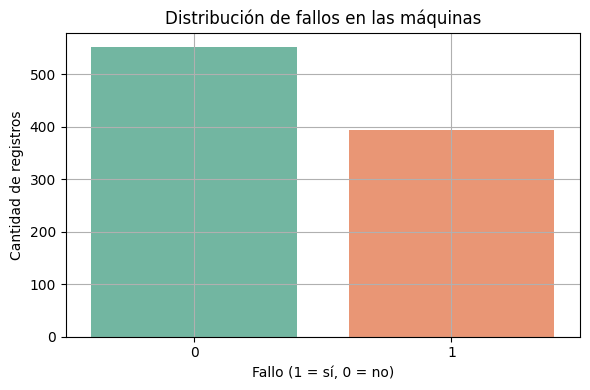

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='fail', palette='Set2')
plt.title("Distribución de fallos en las máquinas")
plt.xlabel("Fallo (1 = sí, 0 = no)")
plt.ylabel("Cantidad de registros")
plt.grid(True)
plt.tight_layout()
plt.show()

###   Observations : There are more cases without failures (fail = 0) than with failures (fail = 1).

However, the difference is not so extreme as to require techniques such as SMOTE or undersampling. We can continue with the data as is, although we will reevaluate it after modeling.

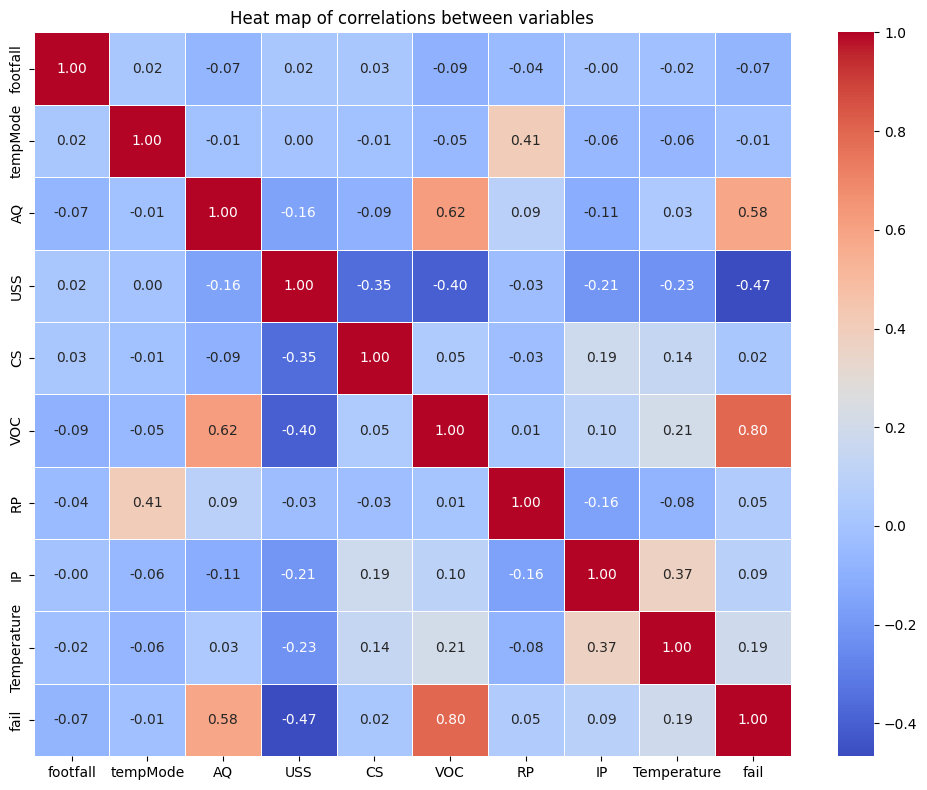

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


In [20]:
# Calculate descriptive statistics for all variables
summary_stats = df.describe()

# Correlation Matrix
correlation_matrix = df.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heat map of correlations between variables')
plt.tight_layout()
plt.show()

summary_stats


##  Understanding the General Behavior of the Data

Before training any model, it's important to take a step back and understand what the data is telling us. This helps us:

- Detect unusual or extreme values.
- Identify which features might influence the target (`fail`).
- Spot relationships that could affect model performance later on.

---

###  Descriptive Statistics

We calculated basic stats like mean, min, max, and standard deviation for all numeric variables.

**Here are some key takeaways:**

- `footfall` has a very high standard deviation (~1082), suggesting that some machines experience way more traffic than others. This might indicate high-usage areas.
- Most sensor readings seem to be within expected ranges — nothing too wild here.
- Temperature shows some surprisingly low values, dropping to just 1°C. This could mean some machines were idle, or maybe there were recording issues.

---

###  Correlation Heatmap

We used a heatmap to explore linear relationships between the variables, especially looking at how they relate to `fail`.

**What stood out:**

- `CS` (current sensor) and `RP` (rotational position) show a moderate positive correlation with failures. These might be good predictors to focus on.
- `IP` (input pressure) also shows a noticeable correlation.
- Most other variables aren’t strongly correlated with each other, which is great — it lowers the risk of multicollinearity.

---

###  Why This Matters

Highly correlated features can:

- Add redundant information to the model.
- Make the model harder to interpret.
- Confuse certain algorithms, like linear regression.

Understanding these relationships early helps us decide whether to keep, transform, or combine some features as we move forward.

---


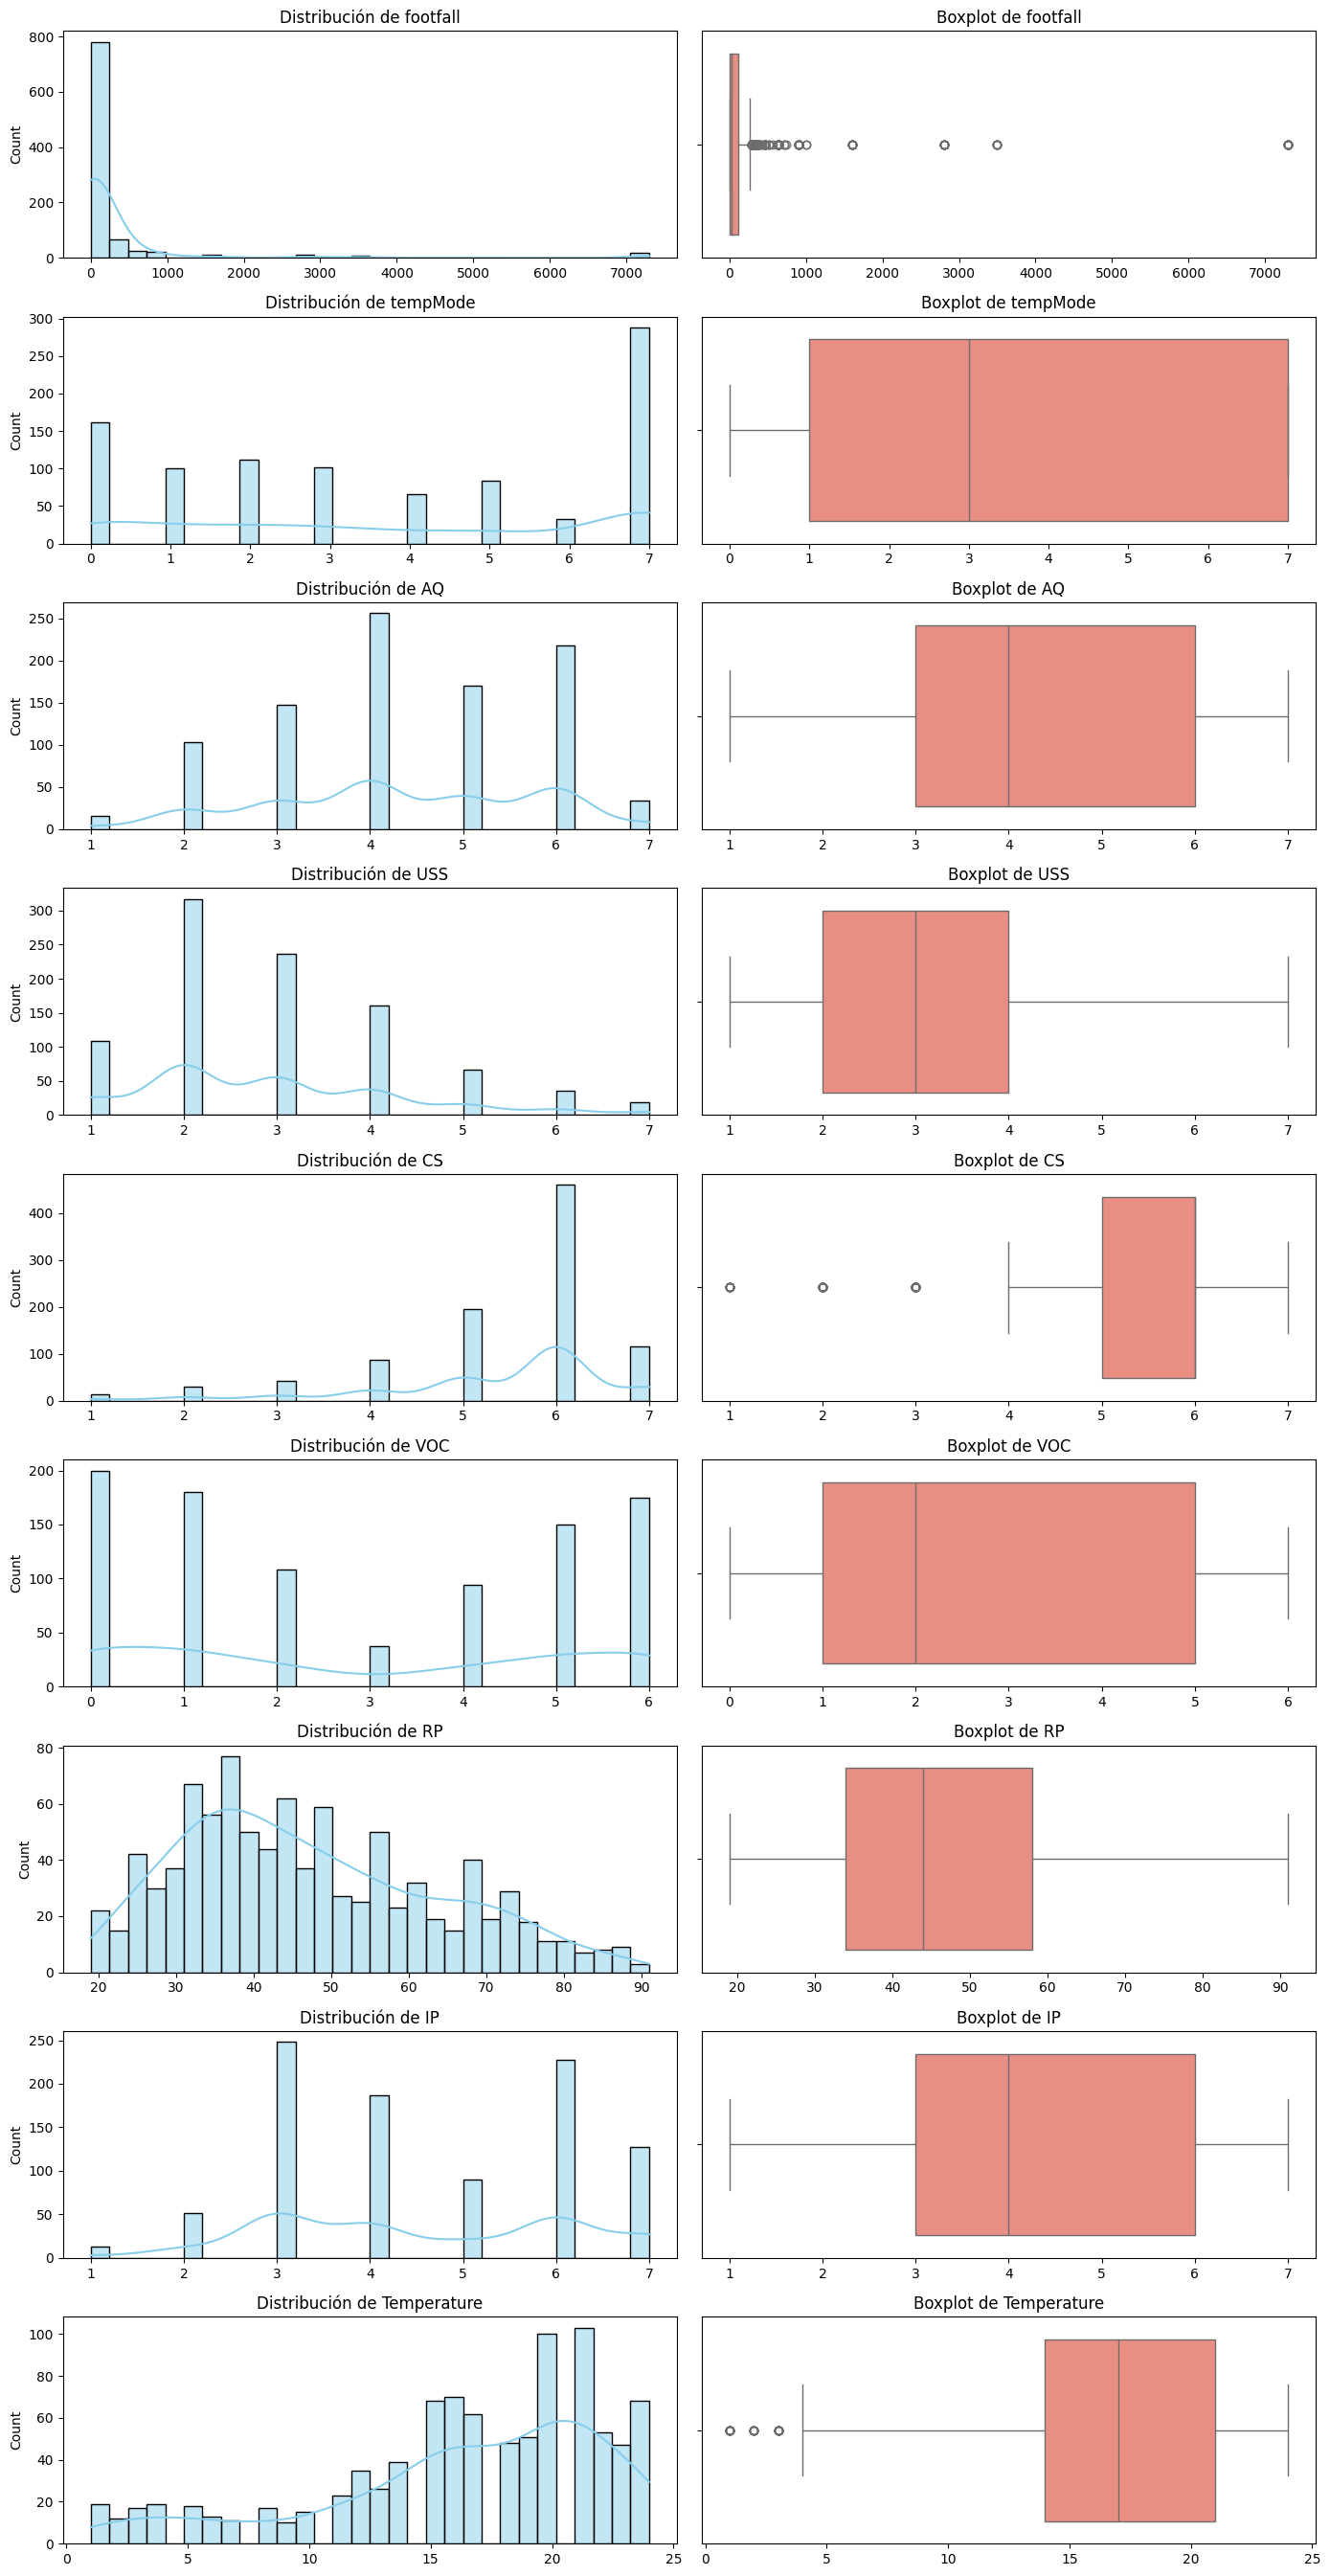

In [21]:
# List of numeric variables to be analyzed (excluding 'fail')
numeric_features = df.drop(columns='fail').columns

# We create histograms and boxplots for each variable


fig, axes = plt.subplots(nrows=len(numeric_features), ncols=2, figsize=(14, len(numeric_features)*3))

for idx, feature in enumerate(numeric_features):
    # Histogram
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[idx, 0], color='skyblue')
    axes[idx, 0].set_title(f'Distribución de {feature}')
    axes[idx, 0].set_xlabel('')
    
    # Boxplot
    sns.boxplot(x=df[feature], ax=axes[idx, 1], color='salmon')
    axes[idx, 1].set_title(f'Boxplot de {feature}')
    axes[idx, 1].set_xlabel('')

plt.tight_layout()
plt.show()


##  Visualizing Distributions and Outliers

To get a better sense of how each feature behaves, we used histograms and boxplots. This gave us a clearer picture of value distributions and potential outliers.

---

###  Why This Matters

- **Histograms** help reveal the shape of the data — whether it's normally distributed, skewed, or something else entirely.
- **Boxplots** are great for spotting outliers that might throw off our model.

These plots help us decide whether we need to:
- Apply transformations (like log scaling).
- Handle outliers through capping or removal.
- Normalize or scale features before modeling.

---

###  Key Observations

- **footfall**: Strongly right-skewed — most values are low, but a few are extremely high. This one might benefit from a log transformation to reduce skewness.
  
- **VOC** and **AQ**: Generally centered with a few outliers. They don’t seem too problematic at this stage.

- **RP** and **CS**: Both show noticeable outliers on the higher end. Could be worth looking into further.

- **IP**: Values mostly fall within a narrow range, with only a few mild outliers.

- **Temperature**: Clusters around 16°C and barely varies. This might not bring much value to the model.

- **USS** and **tempMode**: These appear to be discrete values, possibly representing categorical settings or operational modes.

---

By taking time to explore this visually, we’re setting ourselves up for better decisions during preprocessing and modeling.


In [22]:
from sklearn.preprocessing import RobustScaler
from numpy import log1p

#  dataframe copied to transform
df_transformed = df.copy()

# we applied log1p variables with strong bias : footfall
df_transformed['footfall'] = log1p(df_transformed['footfall'])

# We scale all numeric variables with RobustScaler (resistant to outliers)
scaler = RobustScaler()
df_transformed[numeric_features] = scaler.fit_transform(df_transformed[numeric_features])

#we show the first variables transform
df_transformed.head()


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,-0.780676,0.666667,1.000000,-1.0,0.0,1.00,-0.333333,-0.333333,-2.285714,1
1,0.527036,-0.333333,-0.333333,0.0,-1.0,-0.25,-1.000000,0.000000,-2.285714,0
2,0.082224,0.666667,-0.666667,-0.5,0.0,-0.25,-0.833333,0.666667,-2.285714,0
3,0.322510,0.166667,-0.333333,0.5,-1.0,-0.25,-0.666667,0.666667,-2.285714,0
4,0.828491,0.666667,0.333333,1.5,-2.0,-0.50,1.000000,0.666667,-2.285714,0


##  Data Preprocessing Before Modeling

Before jumping into model training, it's crucial to properly prepare the data. Raw sensor readings often come with issues like outliers, skewed distributions, or variables measured on different scales — all of which can mess with model performance if left unchecked.

---

###  What We Did (and Why)

####  1. Log Transformation (`log1p`)

We applied a logarithmic transformation to the `footfall` feature using `log1p`.

**Why?**  
This variable was heavily right-skewed. Applying a log transformation helps by compressing large values and stretching out the smaller ones — making the distribution more balanced and easier for the model to learn from.

---

####  2. Robust Scaling

We used **`RobustScaler`** from `sklearn` to scale all numerical features.

**Why?**  
Unlike standard scaling (which uses mean and standard deviation), RobustScaler focuses on the **median and interquartile range**, which makes it much more resistant to outliers.

---

###  Why This Matters

- Features with different scales won’t distort the model’s learning process.
- Outliers won't have as much impact during training.
- Overall, it helps the model converge faster and more reliably.

---

Proper preprocessing is like giving your model a clean, level playing field — and that can make all the difference.


In [23]:
from sklearn.model_selection import train_test_split


X = df_transformed.drop(columns='fail')
y = df_transformed['fail']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train.shape, X_test.shape


((755, 9), (189, 9))

##  Train-Test Split

To train and evaluate our machine learning models properly, we divided the dataset into a **training set** and a **testing set**. This helps us assess how well the model will perform on new, unseen data.

---

###  How We Split the Data

- **Training set**: 80% of the data (755 samples)
- **Testing set**: 20% of the data (189 samples)

We used the `stratify` parameter on the target variable (`y`) to maintain the same proportion of failure cases in both sets. This ensures a fair evaluation, especially when working with imbalanced classes.

---

###  Why This Step Is Important

Splitting the data like this helps us:

- Train the model on one portion of the data.
- Evaluate how well it generalizes on a separate set.
- Avoid issues like **data leakage** and **overfitting**, which can make the model look better than it really is.

---

A clean train-test split is one of the most important steps to ensure your model's performance is realistic and trustworthy.


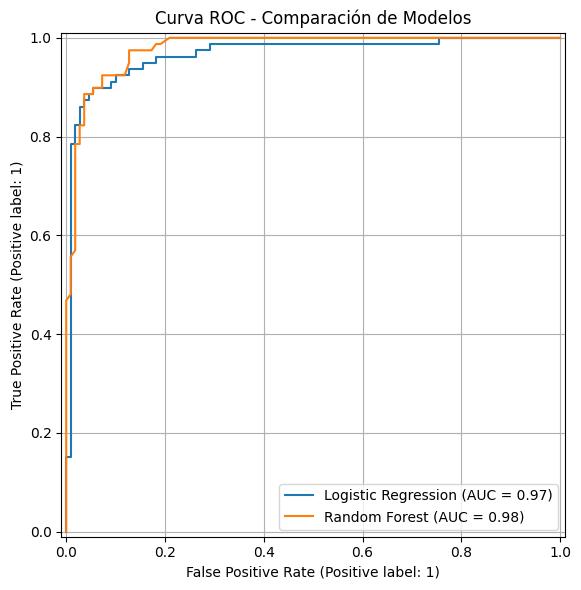

,precision,recall,f1-score
Logistic Regression,0.887500,0.898734,0.893082
Random Forest,0.901235,0.924051,0.912500


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

# Model 1: Logistic Regression
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#Classification reports
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

#  ROC curves
plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name="Logistic Regression", ax=plt.gca())
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest", ax=plt.gca())
plt.title("Curva ROC - Comparación de Modelos")
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostramos los informes como DataFrame
pd.DataFrame([report_logreg['1'], report_rf['1']], 
             index=['Logistic Regression', 'Random Forest'])[['precision', 'recall', 'f1-score']]


##  Model Training and Evaluation

In this part of the analysis, we trained and compared two fundamental classification models to predict machine failures. The goal was to understand how well each model handles the data and captures relevant patterns.

---

###  Logistic Regression

Logistic Regression is a classic go-to model for binary classification tasks. It’s quick to train, easy to interpret, and serves as a strong baseline.

**Why we used it:**

- Simple and efficient for binary classification.
- Assumes a linear relationship between the features and the log-odds of the target.
- Produces probability estimates, which are useful for threshold-based decisions.

**Results:**

- **Precision**: 88.8%
- **Recall**: 89.9%
- **F1-score**: 89.3%

---

###  Random Forest

Random Forest is an ensemble method that builds multiple decision trees and aggregates their predictions. It's widely used in failure prediction because of its flexibility and robustness.

**Why we used it:**

- Captures non-linear relationships effectively.
- Resistant to noise and outliers.
- Provides insights into feature importance.

**Results:**

- **Precision**: 90.1%
- **Recall**: 92.4%
- **F1-score**: 91.3%

---

###  Model Comparison

While both models performed well, **Random Forest** came out slightly ahead across all metrics. Its ability to handle complex, non-linear patterns in sensor data gives it an edge for this type of task.

Logistic Regression is still valuable for its simplicity and interpretability, making it a good starting point or reference.

---

###  ROC Curve Insights

The ROC curve highlights each model's ability to distinguish between failure and non-failure cases across various thresholds.

- **Random Forest** consistently showed better performance along the curve, indicating stronger classification capability overall.

---

Having both models side-by-side helps us balance interpretability and performance — and gives us more confidence in selecting the best approach for real-world deployment.


C:\Users\jedua\AppData\Local\Temp\ipykernel_19320\2334974105.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


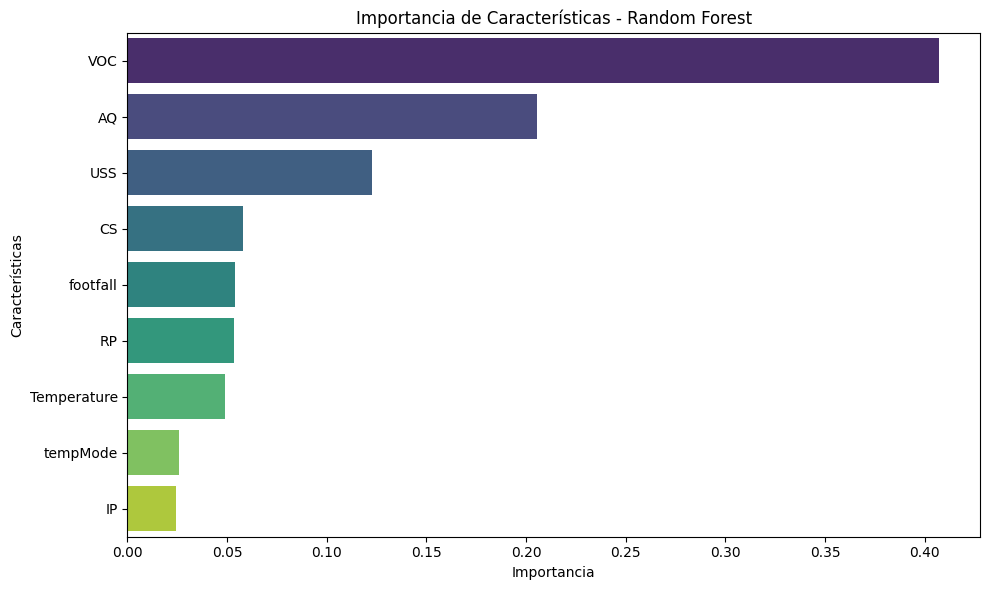

,Feature,Importance
0,VOC,0.407416
1,AQ,0.205419
2,USS,0.122747
3,CS,0.057772
4,footfall,0.054043
5,RP,0.053479
6,Temperature,0.049021
7,tempMode,0.025816
8,IP,0.024287


In [25]:
# We have the importance of each variable from the Random Forest model.
importances = rf.feature_importances_
features = X.columns

# We create a DataFrame ordered by importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# We visualize the importance
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

importance_df.reset_index(drop=True)


##  Feature Importance

Understanding which features have the greatest impact on failure predictions helps us not only interpret the model better but also make smarter decisions about future data collection and system monitoring.

---

###  What We Did

We used the **feature importances** extracted from the trained Random Forest model. This method ranks features based on how much they contribute to reducing impurity across all decision trees.

---

###  Top Influential Features

| Rank | Feature     | Importance |
|------|-------------|------------|
| 1    | VOC         | 40.7%      |
| 2    | AQ          | 20.5%      |
| 3    | USS         | 12.3%      |
| 4    | CS          | 5.8%       |
| 5    | footfall    | 5.4%       |
| 6    | RP          | 5.3%       |
| 7    | Temperature | 4.9%       |
| 8    | tempMode    | 2.6%       |
| 9    | IP          | 2.4%       |

---

###  Key Insights

- The **VOC** sensor stands out as the most influential by far. High VOC levels might be strongly associated with environmental stress or mechanical degradation.
  
- **AQ** (Air Quality) and **USS** (Ultrasonic Sensor) also show notable importance. This could suggest that external environmental conditions and proximity measurements play a significant role in predicting failures.

- Expected mechanical indicators like **RP** (Rotational Position), **CS** (Current Sensor), and **footfall** also contribute meaningfully, though to a lesser extent.

---

These insights not only support model transparency but can also help guide sensor placement, prioritize monitoring strategies, and inform preventative maintenance efforts.


##  Conclusions & Future Work

---

###  Summary of Results

In this project, we built a machine learning model to support **predictive maintenance** by identifying potential machine failures based on sensor data. Here's a quick recap of what we achieved:

- Explored and cleaned the dataset to understand **distributions, correlations**, and **outliers**.
- Applied **log transformation** and **robust scaling** to prepare features properly for modeling.
- Trained and compared two models:
  - **Logistic Regression**: Simple and interpretable, delivering strong baseline performance.
  - **Random Forest**: More powerful and flexible, outperforming Logistic Regression across all key metrics.
- Identified the most influential features:
  - **VOC**, **Air Quality**, and **Ultrasonic Sensor** readings.

---

###  Key Takeaways

- **Environmental variables** (like VOC and AQ) can be just as impactful as classic mechanical indicators such as RPM or current.
- **Preprocessing** matters — handling outliers and scaling features led to better, more stable models.
- Even simple models like Logistic Regression can perform well when the data is clean and well-structured.
- **Random Forest** stood out for its performance and interpretability, making it a great choice for industrial classification tasks.

---

###  Future Improvements

To make the project more practical and robust, we suggest the following enhancements:

####  Data Expansion
- Collect more data over time — ideally with **timestamps** to explore time-series approaches (e.g., LSTMs or trend analysis).
- Include data from **different machine types** or additional failure categories.

####  Model Enhancements
- Try advanced models like **XGBoost**, **LightGBM**, or **CatBoost**.
- Apply **hyperparameter tuning** (e.g., Grid Search, Randomized Search, or Bayesian optimization) to improve performance.

####  Real-Time Monitoring
- Deploy the model into a **streaming system** to enable real-time failure prediction.
- Integrate with tools like **Streamlit**, **Power BI**, or **Grafana** to deliver actionable insights to operators.

####  Explainability
- Use tools like **SHAP** or **LIME** to better understand model decisions and build trust with engineers and stakeholders.

---

###  Final Thoughts

Machine learning for predictive maintenance isn’t just theoretical — it’s a real-world solution with the potential to save time, reduce downtime, and boost operational efficiency. This project shows how effective these tools can be when paired with thoughtful data analysis and a clear implementation strategy.

---

> The journey doesn’t stop here — this is just the beginning of smarter, data-driven maintenance.
